In [12]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy import linalg

import sys
sys.path.insert(0,'..')
import specsens as ss

In [13]:
sample_freq = 1e6  # in Hz
length = 1.0  # in s
signal_strength = 0.0  # in dB
noise_strength = 0.0  # in dB

wm = ss.WirelessMicrophone(f_sample=sample_freq,
                           t_sec=length)  # either specify length in seconds
# wm = ss.WirelessMicrophone(f_sample=sample_freq, num_samples=1e5) # or number of samples
sig = wm.get_signal(f_center=1e5,
                    f_deviation=15000,
                    f_modulation=3900,
                    dB=signal_strength)

# print('wm.f_sample:     %6.2f' % (wm.f_sample))
# print('wm.num_samples:  %9d' % (wm.num_samples))
# print('wm.t_sec:        %6.2f' % (wm.t_sec))

wgn = ss.WhiteGaussianNoise(f_sample=sample_freq,
                            t_sec=length)  # either specify length in seconds
# wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length) # or number of samples
noise = wgn.get_signal(dB=noise_strength)

# print('wgn.f_sample:    %6.2f' % (wgn.f_sample))
# print('wgn.num_samples: %9d' % (wgn.num_samples))
# print('wgn.t_sec:       %6.2f' % (wgn.t_sec))

assert wm.num_samples == wgn.num_samples
num_samples = wm.num_samples

both = sig + noise  # create actual signal ('both') comprising of signal and additive white gaussian noise (AWGN)

print('Signal power:    %6.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:     %6.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:             %6.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Mean:            %6.2f ' % (np.abs(noise.mean())))
print('Var:             %6.2f ' % (np.abs(noise.var())))
print('Num Samples:     %9d ' % (num_samples))

Signal power:      0.00 dB
Noise power:       0.00 dB
SNR:              -0.00 dB
Mean:              0.00 
Var:               1.00 
Num Samples:       1000000 


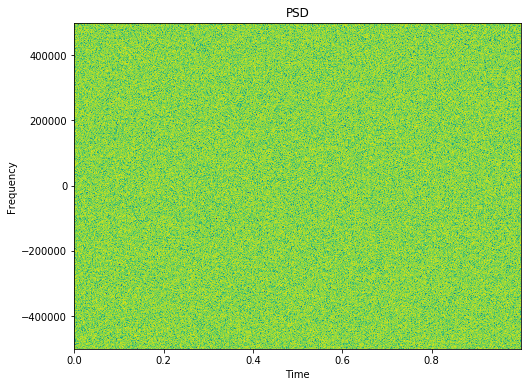

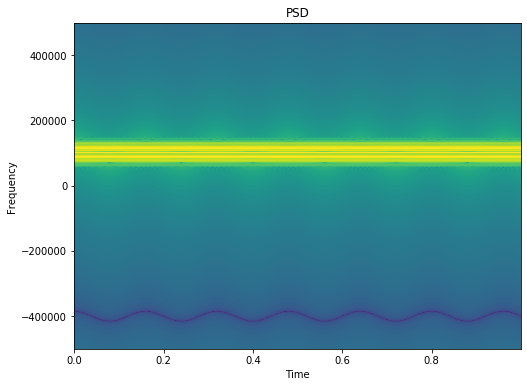

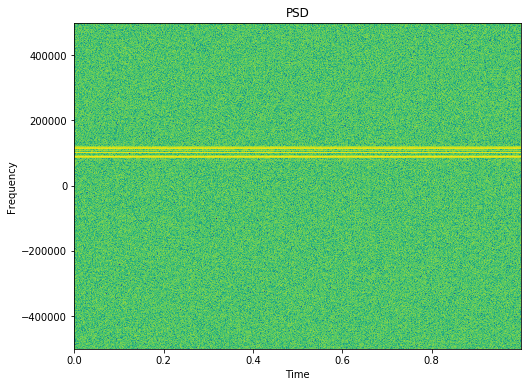

In [14]:
# Plot the resulting signals using matplotlib

plt.figure(figsize=(8, 6))
plt.specgram(noise,
             NFFT=1024,
             Fs=sample_freq,
             scale='dB',
             cmap='viridis',
             noverlap=0,
             mode='psd',
             window=signal.get_window('hann', 1024))
plt.title("PSD")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 6))
plt.specgram(sig,
             NFFT=1024,
             Fs=sample_freq,
             scale='dB',
             cmap='viridis',
             noverlap=0,
             mode='psd',
             window=signal.get_window('hann', 1024))
plt.title("PSD")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 6))
plt.specgram(both,
             NFFT=1024,
             Fs=sample_freq,
             scale='dB',
             cmap='viridis',
             noverlap=0,
             mode='psd',
             window=signal.get_window('hann', 1024))
plt.title("PSD")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

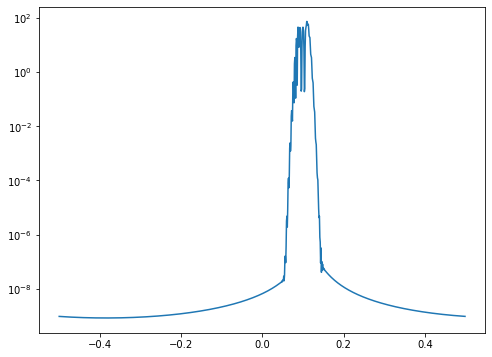

Energy signal 1024.0
Energy signal real 0.001024
Snip length 0.001024
Snip energy 0.001024
Energy from psd 1023.9999987996018
Power from psd 1.0


In [65]:
from scipy import fft

class Stft:

    def __init__(self, n=1024, window='flattop'):
        assert ss.util.is_power2(n)
        self.n = n
        self.window = signal.get_window(window, self.n)

    def fft(self, sig):
        '''Compute FFT and spectrum shifted to natural order.'''
        f = fft.fftshift(fft.fftfreq(len(sig), 1))
        s = fft.fftshift(fft.fft(sig))
        return f, s

    def apply_window(self, sig):
        return sig * self.window

    def stft_helper(self, sig):
        return self.fft(self.apply_window(sig))

    def stft(self, sig):
        segs = [sig[i:i + self.n] for i in range(0, len(sig), self.n)]
        for seg in segs:
            if len(seg) != self.n:
                break
            f, x = self.stft_helper(seg)
            yield f, x

    def apply_psd(self, sig, f_sample):
#         return np.abs(sig)**2. / (len(sig) * f_sample)
        return np.abs(sig)**2. / ((self.window**2).sum())

    def psd(self, sig, f_sample):
        for f, x in self.stft(sig):
            yield f, self.apply_psd(x, f_sample)

    def spectogram(self, sig, f_sample, dB=True):
        tl = list()
        xl = list()
        if dB:
            dB_func = lambda x : ss.util.dB(x)
        else:
            dB_func = lambda x : x
        for i, (f, x) in enumerate(self.psd(sig, f_sample)):
            tl.append(i*self.n*1./f_sample)
            xl.append(x)
        xl = np.swapaxes(xl, 0, 1)
        return f, tl, xl


# sft = ss.Stft(n=1024, window='flattop')
sft = Stft(n=1024, window='flattop')
f, t, x = sft.spectogram(sig, sample_freq, False)

psd = x[:, 2]
plt.figure(figsize=(8, 6))
plt.semilogy(f, psd)
# plt.semilogy(psd)
plt.show()

snip_length = (1./sample_freq)*1024 
snip = sig[1024*2:1024*(2+1)]
en_sig = ss.EnergyDetector.get(snip)
print(f'Energy signal {en_sig}')
print(f'Energy signal real {1/sample_freq * en_sig}')

print(f'Snip length {snip_length}')
print(f'Snip energy {ss.util.signal_energy(snip, snip_length)}')

def get_energy_from_psd(psd):
    return np.sum(psd)

def get_power_from_psd(psd, f):
    df = f[1] - f[0]
    return np.sum(psd) * df

get_energy_from_psd(psd)

print(f'Energy from psd {get_energy_from_psd(psd[512:800])}')
print(f'Power from psd {get_power_from_psd(psd, f)}')

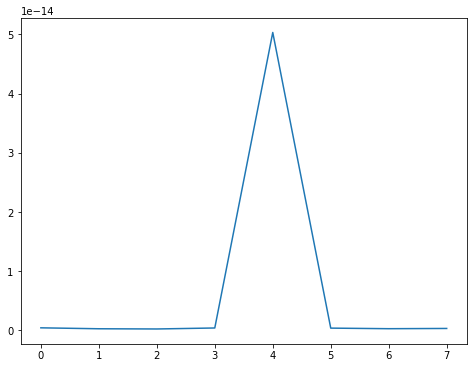

In [16]:
class FreqED:

    def __init__(self, num_bands, fs, fft_len, f):
        self.num_bands = num_bands
        self.fft_len = fft_len
        self.di = fft_len / num_bands
        self.df = f[1] - f[0]
        self.fs = fs
        self.f = f
        assert np.isclose(self.df, (self.fs/self.fft_len))

    def energy(self, ps):
        return np.sum(np.abs(ps) ** 2)/self.fs

    def segs(self, ps):
        f_segs = list()
        ps_segs = list()
        for i in range(int(self.num_bands)):
            idx1 = int(i*self.di)
            idx2 = int((i+1)*self.di)
            f_segs.append(self.f[idx1:idx2])
            ps_segs.append(ps[idx1:idx2])
        return f_segs, ps_segs

    def detect(self, ps):
        f_segs, ps_segs = self.segs(ps)
        en_segs = list()
        for i in range(int(self.num_bands)):
#             plt.figure(figsize=(8, 6))
#             plt.semilogy(f_segs[i], ps_segs[i])
#             plt.show()
            en_segs.append(self.energy(ps_segs[i]))
        return en_segs


ed = FreqED(num_bands=8, fs=sample_freq, fft_len=1024, f=f)
en = ed.detect(x[:, 2])

plt.figure(figsize=(8, 6))
plt.plot(en)
plt.show()